In [1]:
import chess
import chess.svg
import chess.polyglot

from IPython.display import SVG

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv 
import matplotlib.cm as cm

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.models import load_model
import h5py

Using TensorFlow backend.


In [2]:
class ChessAI_Basic:
    def __init__(self, color, depth, num_known_moves, verbose=False):
        
        # Color is True if white, False if black
        self.color = color
        self.depth = depth
        self.num_known_moves = num_known_moves
        self.verbose = verbose
        
        self.tables = {
            'pawn': [
            0,  0,  0,  0,  0,  0,  0,  0,
            5, 10, 10,-20,-20, 10, 10,  5,
            5, -5,-10,  0,  0,-10, -5,  5,
            0,  0,  0, 20, 20,  0,  0,  0,
            5,  5, 10, 25, 25, 10,  5,  5,
            10, 10, 20, 30, 30, 20, 10, 10,
            50, 50, 50, 50, 50, 50, 50, 50,
            0,  0,  0,  0,  0,  0,  0,  0],

        'knight': [
            -50,-40,-30,-30,-30,-30,-40,-50,
            -40,-20,  0,  5,  5,  0,-20,-40,
            -30,  5, 10, 15, 15, 10,  5,-30,
            -30,  0, 15, 20, 20, 15,  0,-30,
            -30,  5, 15, 20, 20, 15,  5,-30,
            -30,  0, 10, 15, 15, 10,  0,-10,
            -40,-20,  0,  0,  0,  0,-20,-40,
            -50,-40,-30,-30,-30,-30,-40,-50],

        'bishop': [
            -20,-10,-10,-10,-10,-10,-10,-20,
            -10,  5,  0,  0,  0,  0,  5,-10,
            -10, 10, 10, 10, 10, 10, 10,-10,
            -10,  0, 10, 10, 10, 10,  0,-10,
            -10,  5,  5, 10, 10,  5,  5,-10,
            -10,  0,  5, 10, 10,  5,  0,-10,
            -10,  0,  0,  0,  0,  0,  0,-10,
            -20,-10,-10,-10,-10,-10,-10,-20],

        'rook': [
              0,  0,  0,  5,  5,  0,  0,  0,
             -5,  0,  0,  0,  0,  0,  0, -5,
             -5,  0,  0,  0,  0,  0,  0, -5,
             -5,  0,  0,  0,  0,  0,  0, -5,
             -5,  0,  0,  0,  0,  0,  0, -5,
             -5,  0,  0,  0,  0,  0,  0, -5,
              5, 10, 10, 10, 10, 10, 10,  5,
             0,  0,  0,  0,  0,  0,  0,  0],

        'queen': [
            -20,-10,-10, -5, -5,-10,-10,-20,
            -10,  0,  0,  0,  0,  0,  0,-10,
            -10,  5,  5,  5,  5,  5,  0,-10,
              0,  0,  5,  5,  5,  5,  0, -5,
             -5,  0,  5,  5,  5,  5,  0, -5,
            -10,  0,  5,  5,  5,  5,  0,-10,
            -10,  0,  0,  0,  0,  0,  0,-10,
            -20,-10,-10, -5, -5,-10,-10,-20],
        
        'king_mid': [
             20, 30, 10,  0,  0, 10, 30, 20,
             20, 20,  0,  0,  0,  0, 20, 20,
            -10,-20,-20,-20,-20,-20,-20,-10,
            -20,-30,-30,-40,-40,-30,-30,-20,
            -30,-40,-40,-50,-50,-40,-40,-30,
            -30,-40,-40,-50,-50,-40,-40,-30,
            -30,-40,-40,-50,-50,-40,-40,-30,
            -30,-40,-40,-50,-50,-40,-40,-30],
        
        'king_end': [
            -50,-40,-30,-20,-20,-30,-40,-50,
            -30,-20,-10,  0,  0,-10,-20,-30,
            -30,-10, 20, 30, 30, 20,-10,-30,
            -30,-10, 30, 40, 40, 30,-10,-30,
            -30,-10, 30, 40, 40, 30,-10,-30,
            -30,-10, 20, 30, 30, 20,-10,-30,
            -30,-30,  0,  0,  0,  0,-30,-30,
            -50,-30,-30,-30,-30,-30,-30,-50]
        }
            
    def dfs(self, board, alpha, beta, depth_count, is_player):
        if depth_count == 0:
            board_score = self.evaluateBoard(board)
                        
            # If AI is black, then we want to flip sign to maximize black score
            if self.color == False:
                board_score = -board_score
            
            return board_score
        
        else:
            # If it is AI turn to move, then we aim to maximize score
            if is_player:
                best_score = -100000
                
                for move in board.legal_moves:
                    board.push(move)
                    
                    best_score = max(best_score, self.dfs(board, alpha, beta, depth_count - 1, False))
                    
                    board.pop()
                    
                    # Find minimum score possible for maximum player
                    alpha = max(alpha, best_score)
                    
                    # If minimum score possible for max player is larger than max score for min player, 
                    # return best_score
                    if alpha >= beta:
                        return best_score
                    
                return best_score
                    
            # Otherwise, we aim to minimize
            else:
                best_score = 100000
                
                for move in board.legal_moves:
                    board.push(move)
                    
                    best_score = min(best_score, self.dfs(board, alpha, beta, depth_count - 1, True))
                    
                    board.pop()
                    
                    # Find minimum score possible for maximum player
                    beta = min(beta, best_score)
                    
                    # If minimum score possible for max player is larger than max score for min player, 
                    # return best_score
                    if alpha >= beta:
                        return best_score
                        
                return best_score
            
    def selectMove(self, board, turn_number):
        try:
            if turn_number >= self.num_known_moves:
                raise ValueError
            move = chess.polyglot.MemoryMappedReader("fruit.bin").weighted_choice(board).move
            if verbose:
                print("Found known move.")
            return move
        
        except:
            if verbose:
                print("Calculating my own move!")
            best_move = None
            best_score = -99999
            alpha = -100000
            beta = 100000

            for move in board.legal_moves:
                if best_move is None:
                    best_move = move
                board.push(move)
                move_score = self.dfs(board, alpha, beta, self.depth - 1, False)
                board.pop()

                if best_score < move_score:
                    best_score = move_score
                    best_move = move

                alpha = max(best_score, alpha)
            
            return best_move
    
    # Rudimentary board evaluation function
    # Calculates score of board based on material on board and position of pieces
    def evaluateBoard(self, board):
        if board.is_checkmate():
            if board.turn:
                return 100000
            else:
                return -100000
        if board.is_stalemate():
            return 0
        if board.is_insufficient_material():
            return 0
            
        # Calculate positional difference
        material_score = 0
        position_score = 0
        
        # Pawn difference
        white_pawns = board.pieces(chess.PAWN, chess.WHITE)
        black_pawns = board.pieces(chess.PAWN, chess.BLACK)
        
        material_score += 100*(len(white_pawns)-len(black_pawns))
        
        for pos in white_pawns:
            position_score += self.tables['pawn'][pos]

        for pos in black_pawns:
            position_score -= self.tables['pawn'][chess.square_mirror(pos)]
        
        # Knight difference
        white_knights = board.pieces(chess.KNIGHT, chess.WHITE)
        black_knights = board.pieces(chess.KNIGHT, chess.BLACK)
        
        material_score += 320*(len(white_knights)-len(black_knights))
        
        for pos in white_knights:
            position_score += self.tables['knight'][pos]

        for pos in black_knights:
            position_score -= self.tables['knight'][chess.square_mirror(pos)]
            
        # Bishop difference
        white_bishops = board.pieces(chess.BISHOP, chess.WHITE)
        black_bishops = board.pieces(chess.BISHOP, chess.BLACK)
        
        material_score += 350*(len(white_bishops)-len(black_bishops))
        
        for pos in white_bishops:
            position_score += self.tables['bishop'][pos]

        for pos in black_bishops:
            position_score -= self.tables['bishop'][chess.square_mirror(pos)]
            
        # Rook difference
        white_rooks = board.pieces(chess.ROOK, chess.WHITE)
        black_rooks = board.pieces(chess.ROOK, chess.BLACK)
        
        material_score += 500*(len(white_rooks) - len(black_rooks))
        
        for pos in white_rooks:
            position_score += self.tables['rook'][pos]
        
        for pos in black_rooks:
            position_score -= self.tables['rook'][chess.square_mirror(pos)]
            
        # Queen difference
        white_queens = board.pieces(chess.QUEEN, chess.WHITE)
        black_queens = board.pieces(chess.QUEEN, chess.BLACK)
        
        material_score += 900*(len(white_queens) - len(black_queens))
        
        for pos in white_queens:
            position_score += self.tables['queen'][pos]

        for pos in black_queens:
            position_score -= self.tables['queen'][chess.square_mirror(pos)]   
        
        # King difference
        white_king = board.pieces(chess.KING, chess.WHITE)
        black_king = board.pieces(chess.KING, chess.BLACK)
        
        if len(white_queens) == 0 and len(black_queens) == 0:  
            for pos in white_king:
                position_score += self.tables['king_end'][pos]

            for pos in black_king:
                position_score -= self.tables['king_end'][chess.square_mirror(pos)]
        else:
            for pos in white_king:
                position_score += self.tables['king_mid'][pos]

            for pos in black_king:
                position_score -= self.tables['king_mid'][chess.square_mirror(pos)]

        final_score = material_score + position_score

        return final_score

In [11]:
class ChessAI_ANN:
    def __init__(self, color, depth, num_known_moves, model_name, verbose=False):
        
        # Color is True if white, False if black
        self.color = color
        self.depth = depth
        self.num_known_moves = num_known_moves
        self.verbose = verbose
        
        self.evaluator = load_model(model_name)
            
    def dfs(self, board, alpha, beta, depth_count, is_player):
        if depth_count == 0:
            board_score = self.evaluateBoard(board)
                        
            # If AI is black, then we want to flip sign to maximize black score
            if self.color == False:
                board_score = -board_score
            
            return board_score
        
        else:
            # If it is AI turn to move, then we aim to maximize score
            if is_player:
                best_score = -100000
                
                for move in board.legal_moves:
                    board.push(move)
                    
                    best_score = max(best_score, self.dfs(board, alpha, beta, depth_count - 1, False))
                    
                    board.pop()
                    
                    # Find minimum score possible for maximum player
                    alpha = max(alpha, best_score)
                    
                    # If minimum score possible for max player is larger than max score for min player, 
                    # return best_score
                    if alpha >= beta:
                        return best_score
                    
                return best_score
                    
            # Otherwise, we aim to minimize
            else:
                best_score = 100000
                
                for move in board.legal_moves:
                    board.push(move)
                    
                    best_score = min(best_score, self.dfs(board, alpha, beta, depth_count - 1, True))
                    
                    board.pop()
                    
                    # Find minimum score possible for maximum player
                    beta = min(beta, best_score)
                    
                    # If minimum score possible for max player is larger than max score for min player, 
                    # return best_score
                    if alpha >= beta:
                        return best_score
                        
                return best_score
            
    def selectMove(self, board, turn_number):
        try:
            if turn_number >= self.num_known_moves:
                raise ValueError
            move = chess.polyglot.MemoryMappedReader("fruit.bin").weighted_choice(board).move
            if verbose:
                print("Found known move.")
            return move
        
        except:
            if verbose:
                print("Calculating my own move!")
            best_move = None
            best_score = -99999
            alpha = -100000
            beta = 100000

            for move in board.legal_moves:
                if best_move is None:
                    best_move = move
                board.push(move)
                move_score = self.evaluateBoard(board)
                board.pop()

                if best_score < move_score:
                    best_score = move_score
                    best_move = move

                alpha = max(best_score, alpha)
            
            return best_move
    
    def encode(self, board):
        # Initialize matrix to hold encoded board
        # Each encoded board will be 8x8 with 12 channels at each square. 
        # Piece types are given as:
        # P - 1, N - 2, B - 3, R - 4, Q - 5, K - 6
        # White pieces occupy the first 6 indices, bladck pieces occupy the last 6 indices
        # [P, N, B, R, Q, K, p, n, b, r, q, k]
        encodedBoard = np.zeros((768,), dtype=np.int) 

        # Loop through each of the 64 positions on the board
        # Position 0 is where the Queen's rook initially starts
        for i in range(64):
            # Check if piece exists at specified square
            piece = board.piece_at(i)

            if piece is not None:
                # Get piece information
                piece_type = board.piece_at(i).piece_type
                piece_color = board.piece_at(i).color

                # Adj = 0 if white, 
                adj = 0
                if piece_color == False:
                    adj = 6

                # If piece belongs to playing player, then 
                if piece_color == board.turn:
                    encodedBoard[i*12+(adj + piece_type-1)] = 1
                else:
                    encodedBoard[i*12+(adj + piece_type-1)] = -1
                    
        return encodedBoard
    
    # Rudimentary board evaluation function
    # Calculates score of board based on material on board and position of pieces
    def evaluateBoard(self, board):
        if board.is_checkmate():
            if is_player_turn:
                return -100000
            else:
                return 100000
        if board.is_stalemate():
            return 0
        if board.is_insufficient_material():
            return 0
        if board.is_seventyfive_moves():
            return 0
        
        board_tensor = np.asarray([self.encode(board)])

        final_score = self.evaluator.predict(board_tensor)
        
        if board.turn == False:
            final_score = final_score * -1
        
        return final_score
        

TURN 1 
Calculating my own move!
White:  d2d4


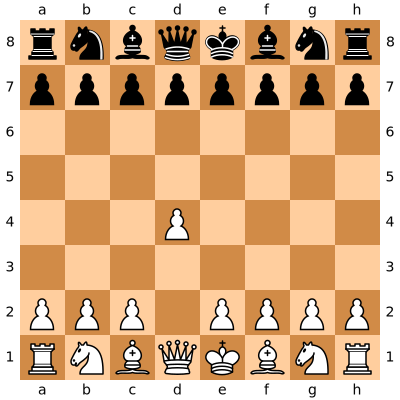

Calculating my own move!
Black:  g8f6


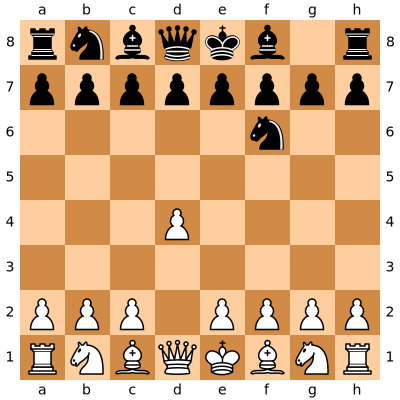

Board Evaluation:  -10
TURN 2 
Calculating my own move!
White:  b1a3


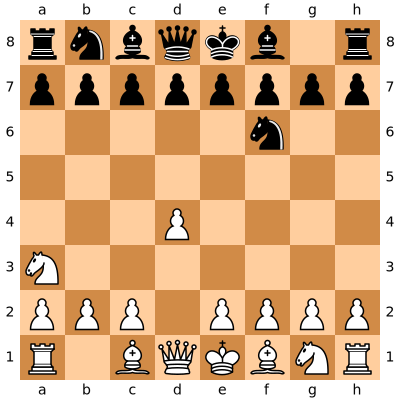

Calculating my own move!
Black:  b8c6


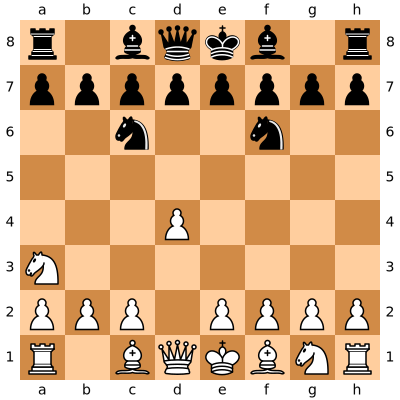

Board Evaluation:  -50
TURN 3 
Calculating my own move!
White:  g1h3


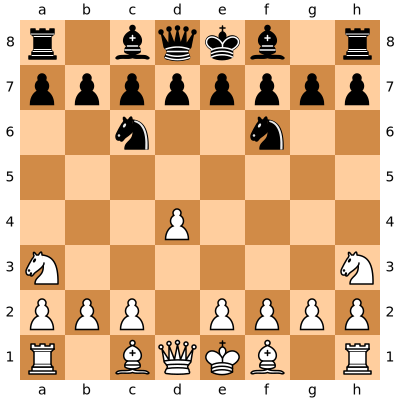

Calculating my own move!
Black:  d7d5


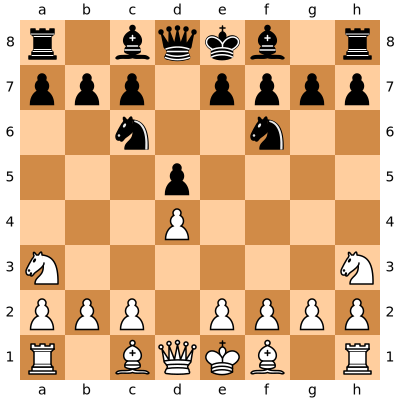

Board Evaluation:  -80
TURN 4 
Calculating my own move!
White:  e2e3


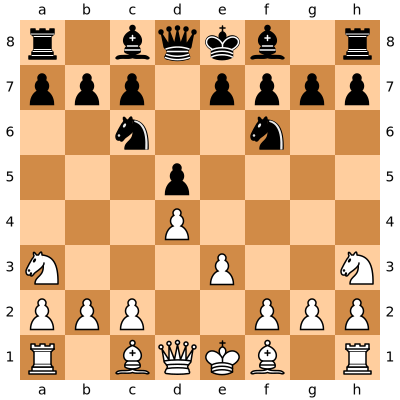

Calculating my own move!
Black:  c8e6


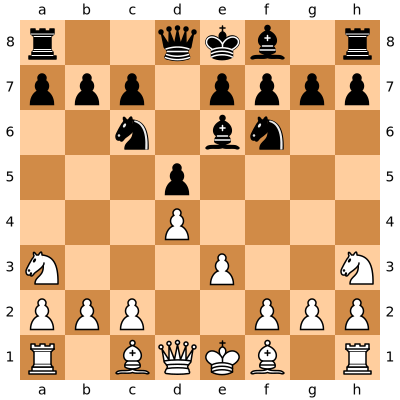

Board Evaluation:  -80
TURN 5 
Calculating my own move!
White:  f1b5


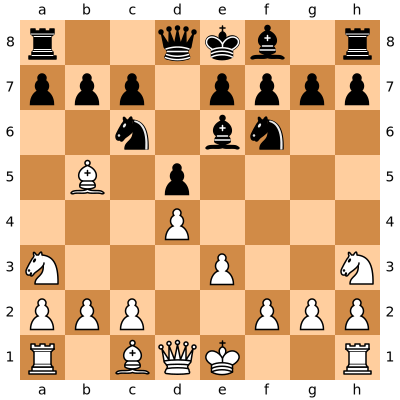

Calculating my own move!
Black:  e6h3


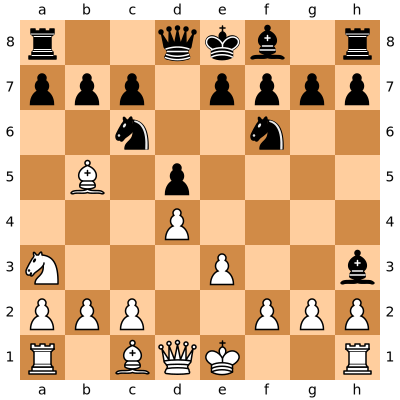

Board Evaluation:  -335
TURN 6 
Calculating my own move!
White:  e1g1


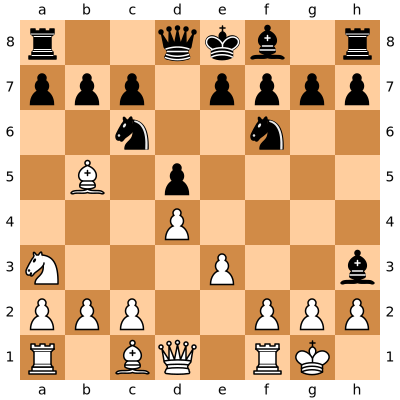

Calculating my own move!
Black:  h3g2


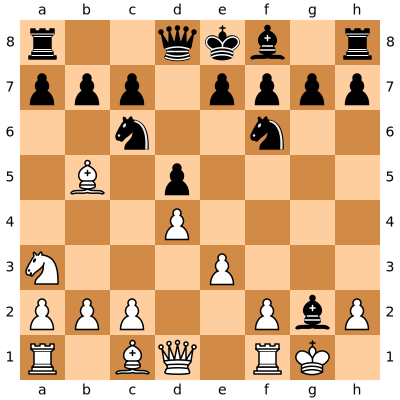

Board Evaluation:  -425
TURN 7 
Calculating my own move!
White:  c1d2


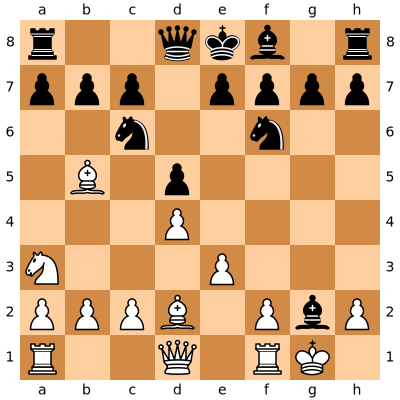

Calculating my own move!
Black:  g2f1


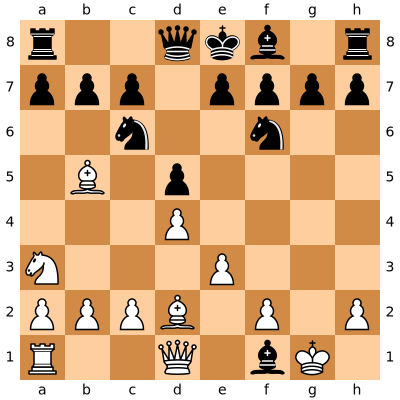

Board Evaluation:  -905
TURN 8 
Calculating my own move!
White:  a1c1


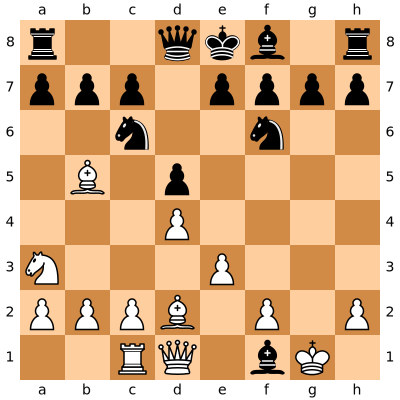

Calculating my own move!
Black:  f1b5


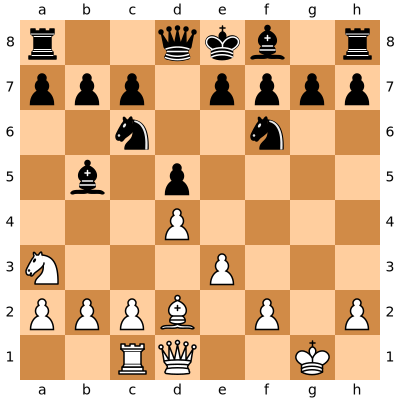

Board Evaluation:  -1270
TURN 9 
Calculating my own move!
White:  d1h5


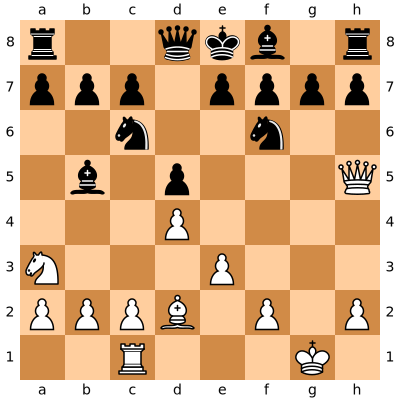

Calculating my own move!
Black:  f6h5


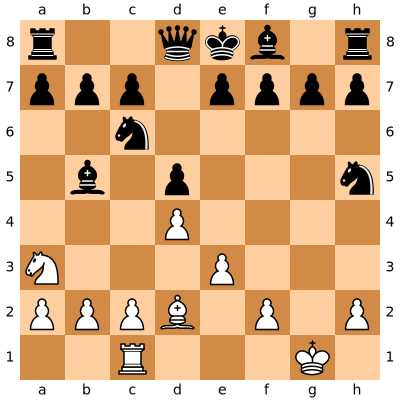

Board Evaluation:  -2125
TURN 10 
Calculating my own move!
White:  e3e4


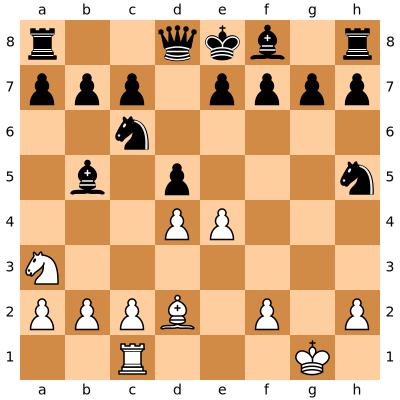

Calculating my own move!
Black:  b5e2


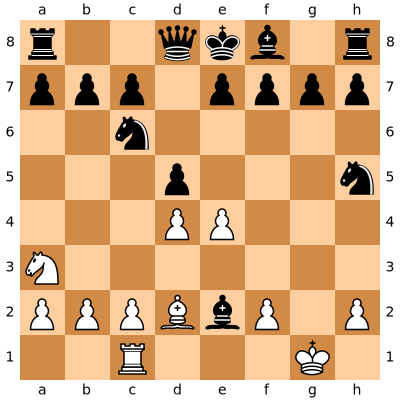

Board Evaluation:  -2105
TURN 11 
Calculating my own move!
White:  e4d5


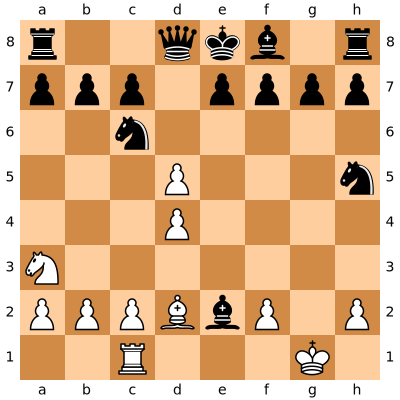

Calculating my own move!
Black:  d8d5


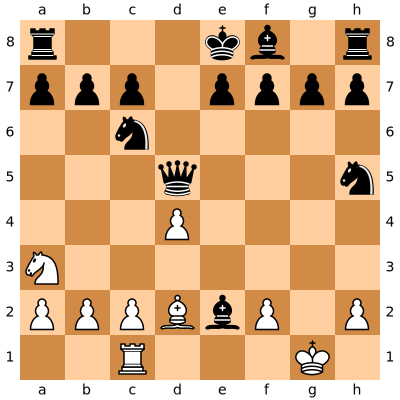

Board Evaluation:  -2115
TURN 12 
Calculating my own move!
White:  b2b4


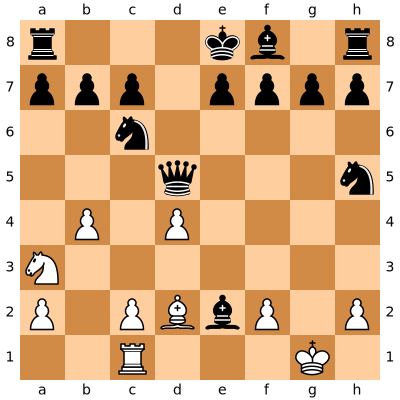

Calculating my own move!
Black:  c6d4


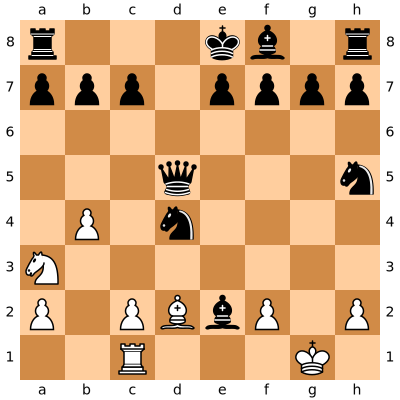

Board Evaluation:  -2255
TURN 13 
Calculating my own move!
White:  b4b5


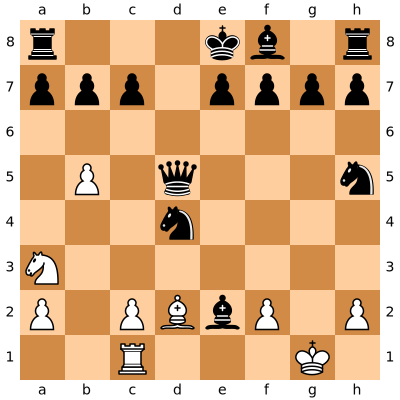

Calculating my own move!
Black:  d5a2


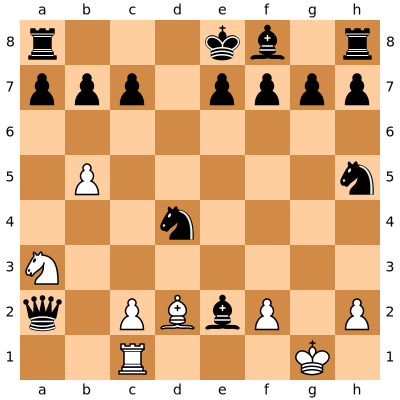

Board Evaluation:  -2340
TURN 14 
Calculating my own move!
White:  a3c4


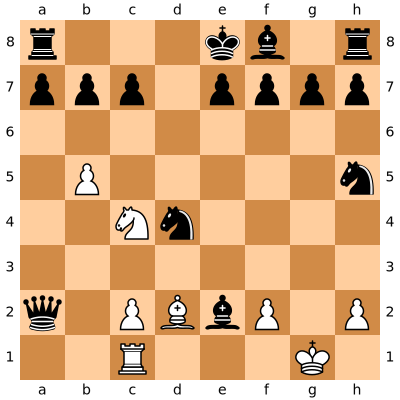

Calculating my own move!
Black:  a2c4


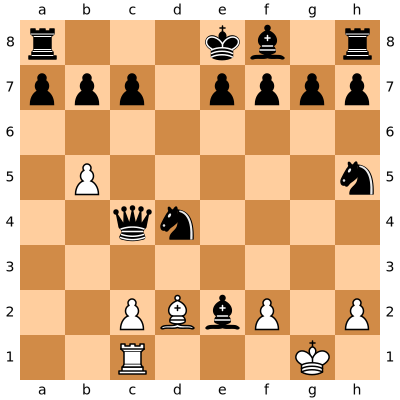

Board Evaluation:  -2645
TURN 15 
Calculating my own move!
White:  g1g2


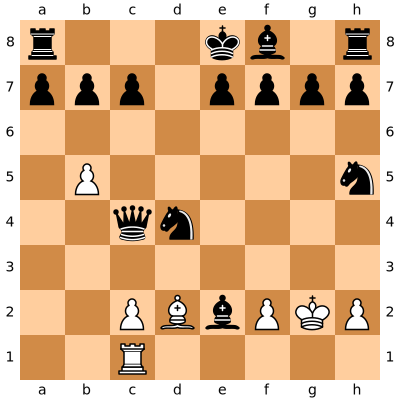

Calculating my own move!
Black:  c4b5


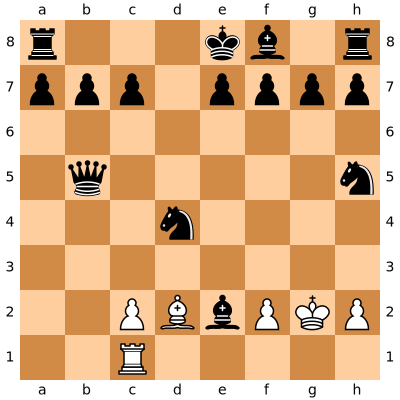

Board Evaluation:  -2755
TURN 16 
Calculating my own move!
White:  d2e3


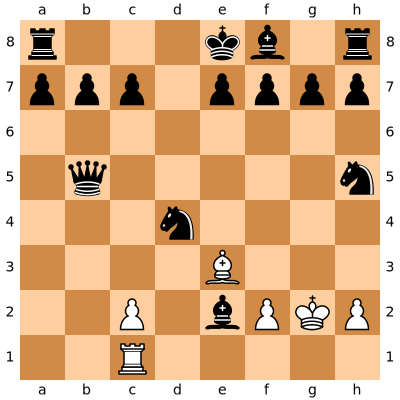

Calculating my own move!
Black:  b5c6


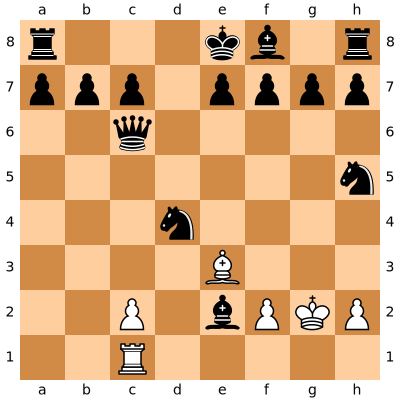

Board Evaluation:  -2750
TURN 17 
Calculating my own move!
White:  g2g1


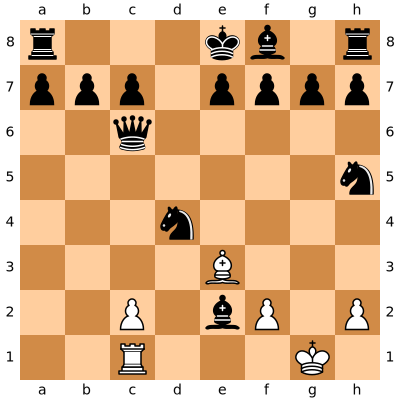

Calculating my own move!
Black:  c6g6


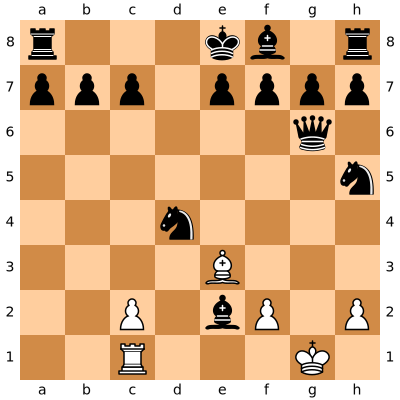

Board Evaluation:  -2735
TURN 18 
Calculating my own move!
White:  e3g5


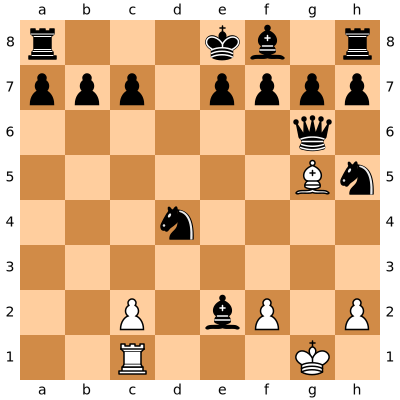

Calculating my own move!
Black:  g6g5


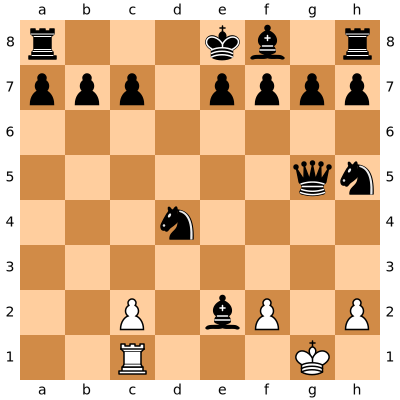

Board Evaluation:  -3095
TURN 19 
Calculating my own move!
White:  g1h1


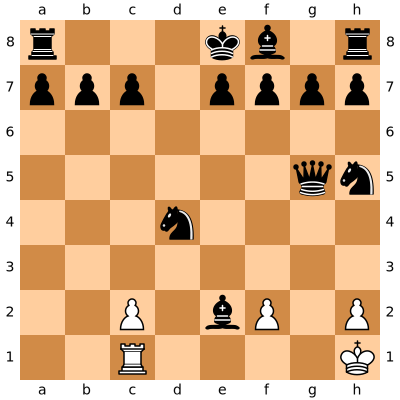

Calculating my own move!
Black:  e2f3


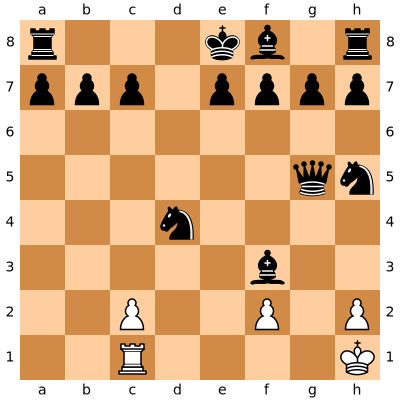

Board Evaluation:  100000
Checkmate!


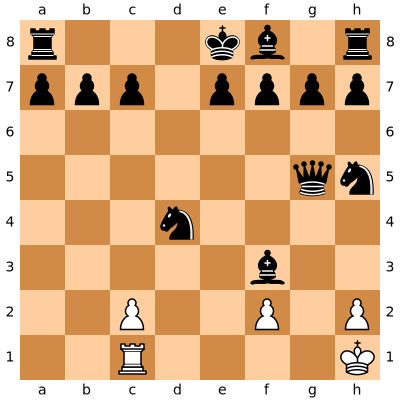

In [13]:
board = chess.Board()
black_AI = ChessAI_Basic(False, 2, 0)
white_AI = ChessAI_ANN(True, 3, 0, 'models/ChessAI_MLP.h5')

turn = 1
white = True
verbose = True
move_history = []
while not board.is_checkmate() and not board.is_stalemate():
    if white:
        print("TURN {} ".format(turn))
        white_move = white_AI.selectMove(board, turn)
        move_history.append(white_move)
        board.push(white_move)
        if verbose:
            print("White: ", white_move)
            display(SVG(chess.svg.board(board=board,size=400)))
        white = False
        
    else:
        turn += 1
        black_move = black_AI.selectMove(board, turn)
        move_history.append(black_move)
        board.push(black_move)
        if verbose:
            print("Black: ", black_move)
            display(SVG(chess.svg.board(board=board,size=400)))
        print("Board Evaluation: ", black_AI.evaluateBoard(board))
        white = True

if board.is_checkmate():
    print("Checkmate!")
    display(SVG(chess.svg.board(board=board,size=400)))
    
if board.is_stalemate():
    print("Stalemate!")
    display(SVG(chess.svg.board(board=board,size=400)))

        

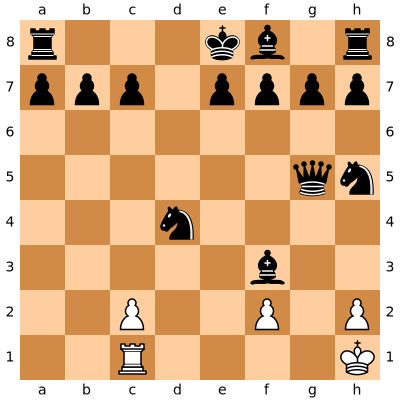

In [14]:
display(SVG(chess.svg.board(board=board,size=400)))

In [ ]:
board = chess.Board()

In [ ]:
print(board)
" ".join(str(board).split("\n"))

In [ ]:
board.fen()
for move in board.legal_moves:
    board.push(move)
    break
import matplotlib.pyplot as plt
    
plt.show(SVG(chess.svg.board(board=board,size=400)))

board.fen()

In [ ]:
board = chess.Board("6R1/3pk3/5pp1/1N2b2p/P3p2P/8/2r2PP1/4K3 b - - 6 36")
print(board.turn)
display(SVG(chess.svg.board(board=board,size=400)))